In [57]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format='retina'


In [58]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pd.Timestamp.now()
# pd.Timestamp.now().strftime('%Y-%m-%d')

Python  version: 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
pandas  version: 1.4.3
numpy   version: 1.23.1
seaborn version: 0.12.2


Timestamp('2023-05-22 01:03:40.229915')

In [59]:
df_path = 'D:\AIB3\pm25_2011_2020\PM2.5\PM2.5(2022).xlsx'
data=pd.read_excel(df_path)
                   #parse_dates=['Date'], index_col = 'Date')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

data_fil = data['13T']
data_fil = data_fil.to_frame()
data_fil.head(10)

,13T
Date,
2022-01-01,20
2022-01-02,20
2022-01-03,23
2022-01-04,31
2022-01-05,33
2022-01-06,37
2022-01-07,37
2022-01-08,32
2022-01-09,39


In [60]:
data_fil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   13T     365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


In [67]:
train = data_fil.loc[data_fil.index < '2022-11-01']
test = data_fil.loc[data_fil.index >= '2022-11-01']

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2022-01-01 to 2022-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   13T     304 non-null    int64
dtypes: int64(1)
memory usage: 4.8 KB


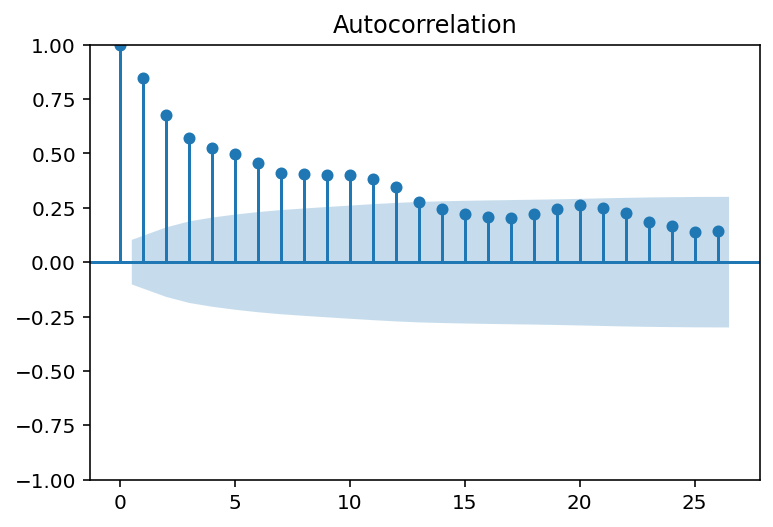

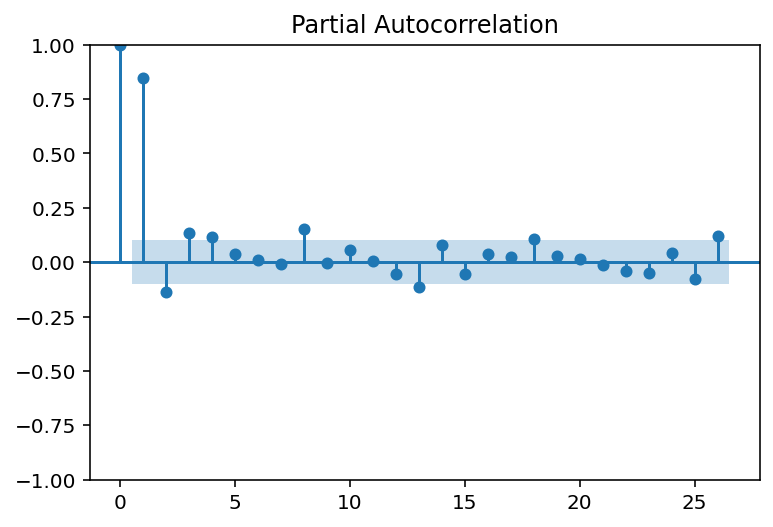

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(data_fil)

pacf_original = plot_pacf(data_fil)

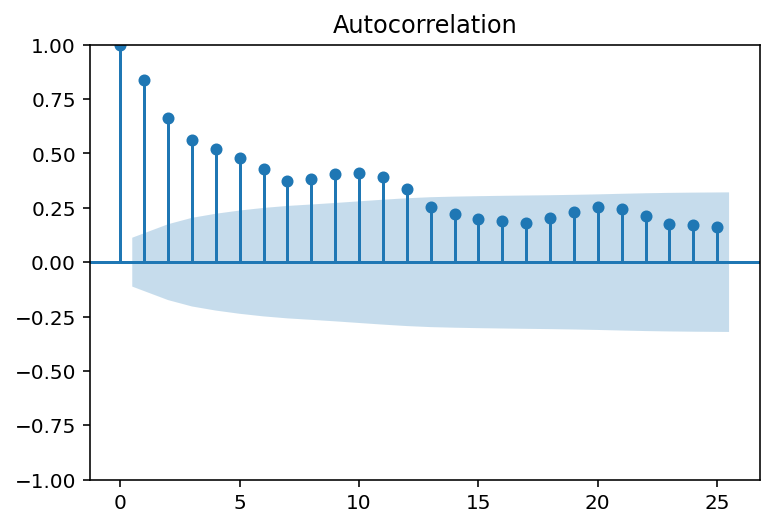

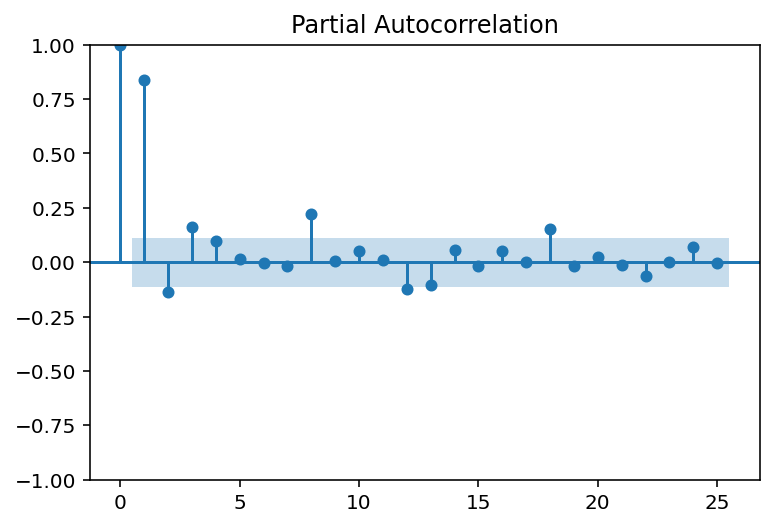

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(train)

pacf_original = plot_pacf(train)

In [71]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(train)
#print(adf_test)
print(f'p-value :  {adf_test[1]}')

p-value :  0.06609893011472467


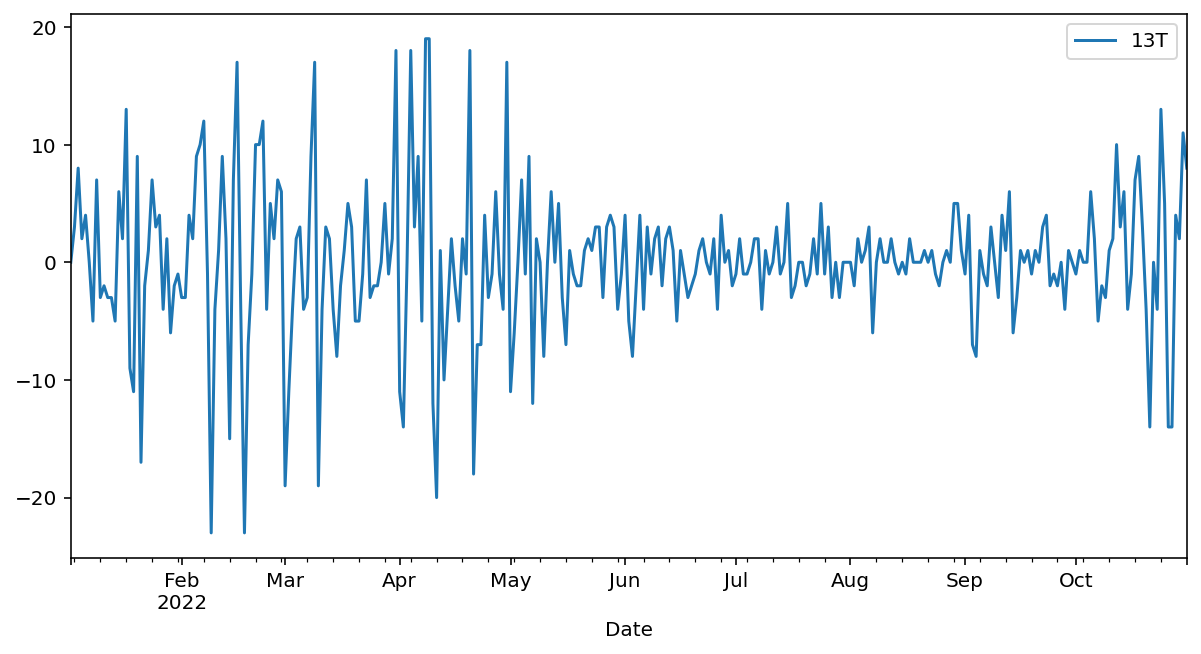

In [72]:
train_diff = train.diff().dropna()
train_diff.plot(figsize=(10,5))
plt.show()

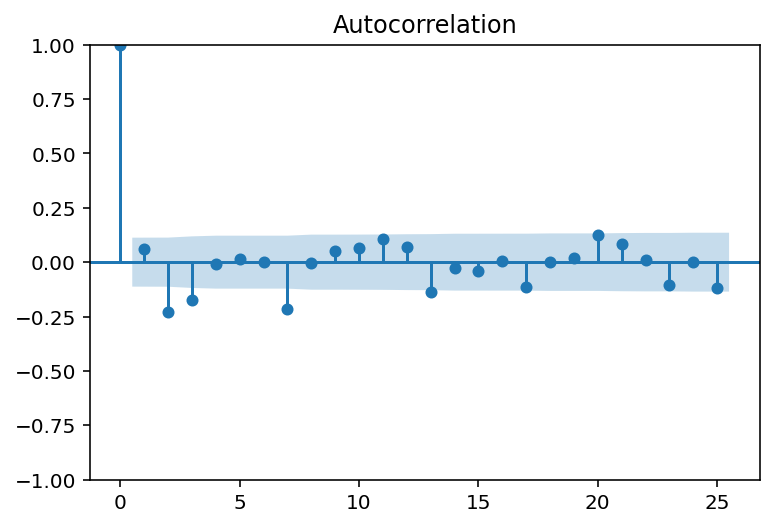

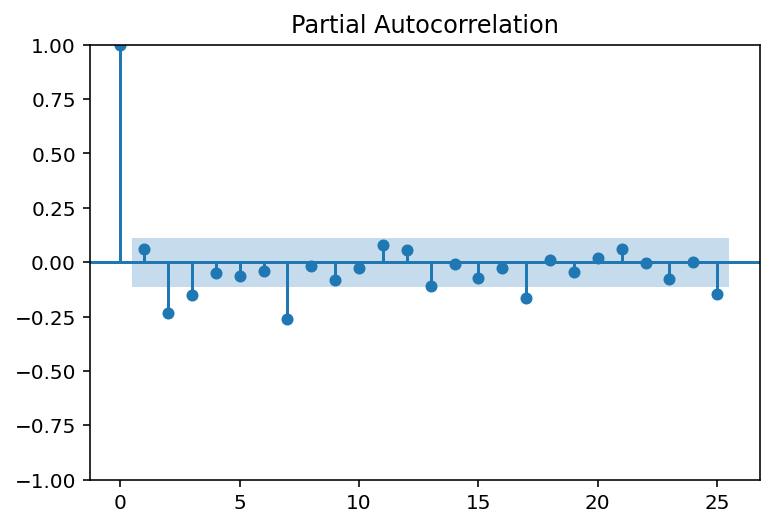

In [73]:
acf_diff = plot_acf(train_diff)

pacf_diff = plot_pacf(train_diff)

<AxesSubplot:xlabel='Date'>

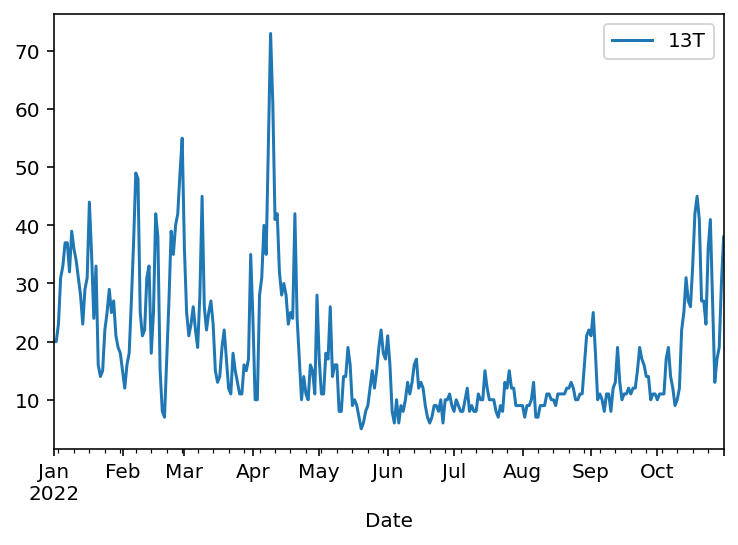

In [74]:
train.plot()

In [75]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    13T   No. Observations:                  304
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -977.253
Date:                Mon, 22 May 2023   AIC                           1960.506
Time:                        01:05:20   BIC                           1971.647
Sample:                    01-01-2022   HQIC                          1964.963
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0713      0.041      1.746      0.081      -0.009       0.151
ar.L2         -0.2336      0.039     -6.012      0.000      -0.310      -0.157
sigma2        37.0495      2.103     17.616      0.0

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


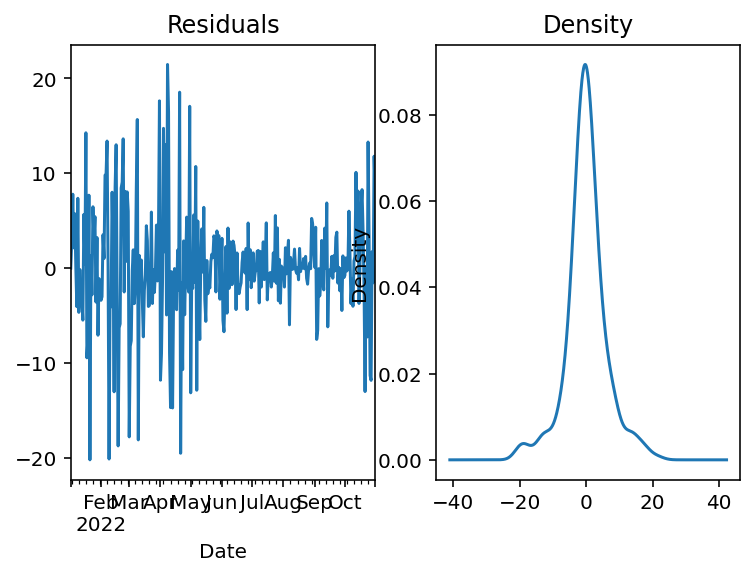

In [76]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax=ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax=ax[1])
plt.show()

density --> normal distibution

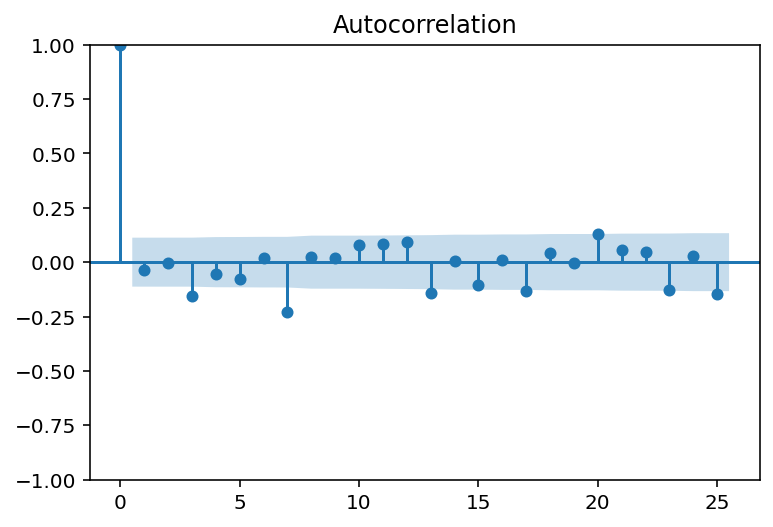

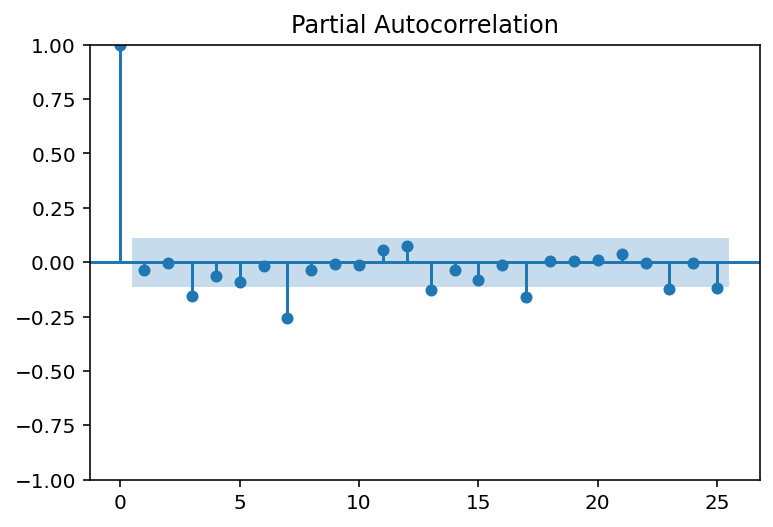

In [77]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

residuals are close to white noise

In [78]:
data_fil.head()

,13T
Date,
2022-01-01,20
2022-01-02,20
2022-01-03,23
2022-01-04,31
2022-01-05,33


<AxesSubplot:xlabel='Date'>

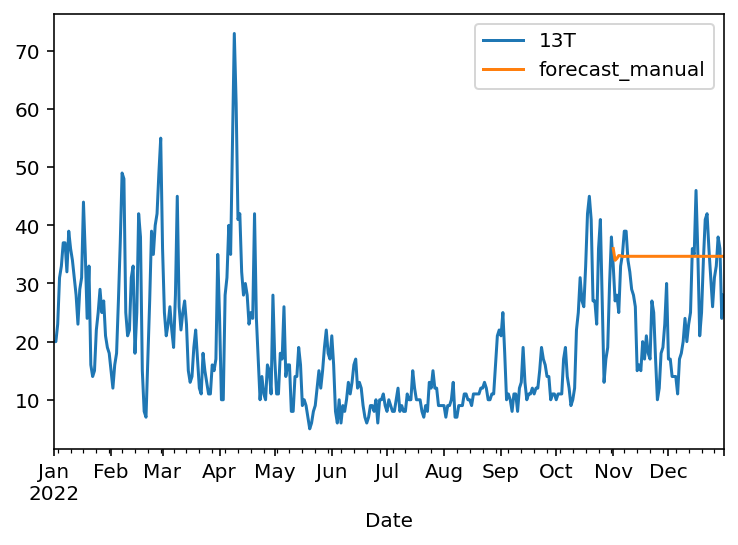

In [79]:
forecast_test = model_fit.forecast(len(test))

data_fil['forecast_manual'] = [None]*len(train) + list(forecast_test)

data_fil.plot()

In [81]:
data_fil.tail().reset_index()

,Date,13T,forecast_manual
0,2022-12-27,33,34.672374
1,2022-12-28,38,34.672374
2,2022-12-29,36,34.672374
3,2022-12-30,24,34.672374
4,2022-12-31,28,34.672374


In [83]:
import pmdarima as pm
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

In [84]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  304
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -961.693
Date:                Mon, 22 May 2023   AIC                           1937.386
Time:                        01:09:51   BIC                           1963.382
Sample:                    01-01-2022   HQIC                          1947.787
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0030      0.074     -0.041      0.967      -0.148       0.142
ar.L1         -0.4079      0.067     -6.074      0.000      -0.539      -0.276
ar.L2          0.5645      0.068      8.352      0.000       0.432       0.697
ma.L1          0.4167      0.075      5.529      0.000       0.269       0.564
ma.L2         -0.8803      0.048    -18.273      0.000      -0.975      -0.786
ma.L3         -0.3608      0.053     -6.832      0.000      -0.464      -0.257
sigma2        33.3152      1.912     17.421      0.000      29.567      37.063
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                86.44
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

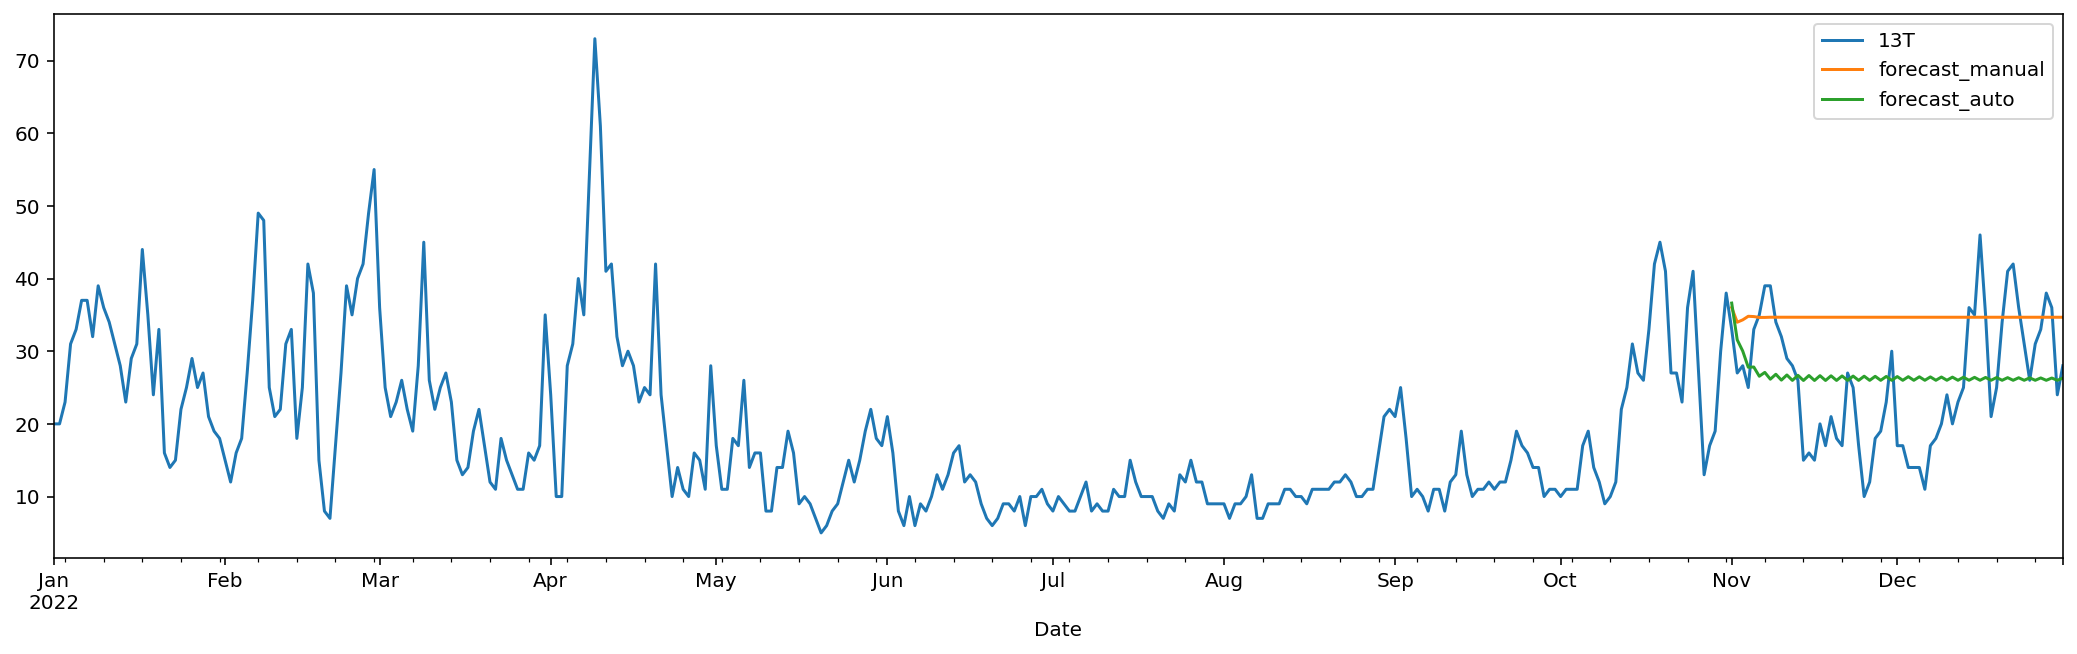

In [88]:
forecast_test_auto = auto_arima.predict(n_periods=len(test))
data_fil['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

data_fil.plot(figsize=(18,5))

In [90]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 10.48263020176714
mape - manual: 0.5798833535890874
rmse - manual: 12.613695654690206


In [92]:
mae = mean_absolute_error(test, forecast_test_auto)
mape = mean_absolute_percentage_error(test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 7.502041057750142
mape - auto: 0.35948789807673237
rmse - auto: 8.744245297214178
